#  Asthma Detection with ResNet
Notebook ini menjelaskan setiap langkah dalam pipeline deteksi asma menggunakan deep learning dengan fitur MFCC dari audio napas pasien.


## 🔧 1. Import Library
Mengimpor semua library yang dibutuhkan, termasuk `librosa` untuk membaca audio, `torch` untuk deep learning, dan `sklearn` untuk split data.

In [1]:
import librosa
import os
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from pathlib import Path


## 📁 2. Load Dataset Audio
Menentukan path ke folder yang berisi file `.wav` suara pernapasan penderita asma, kemudian memuat dan membagi menjadi data latih dan uji.

In [2]:
from pathlib import Path

# Ganti dengan path lokal yang kamu miliki (gunakan raw string agar aman di Windows)
base_path = Path(r"C:/Users/Asus/asthma-detection/Dataset/Fraiwan_dkk/Audio/Asthma")

# Cek apakah path valid
if not base_path.exists():
    raise RuntimeError("❌ Path tidak ditemukan. Pastikan folder sudah benar!")

# Ambil semua file .wav
file_paths = list(base_path.glob("*.wav"))
if not file_paths:
    raise RuntimeError("❌ Tidak ada file .wav ditemukan dalam folder.")

print(f"✅ Ditemukan {len(file_paths)} file audio di: {base_path}")

# Dummy label semua asma (label = 1)
labels = [1] * len(file_paths)

# Split data
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42)



✅ Ditemukan 98 file audio di: C:\Users\Asus\asthma-detection\Dataset\Fraiwan_dkk\Audio\Asthma


## 📊 3. Dataset Class: Ekstraksi MFCC
Menggunakan `librosa.load` untuk membaca audio dan `torchaudio.transforms.MFCC` untuk mengekstrak fitur suara dalam bentuk MFCC.

In [3]:
import librosa

class AsthmaAudioDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = torchaudio.transforms.MFCC(n_mfcc=40)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Gunakan librosa agar lebih stabil di Windows
        waveform, sample_rate = librosa.load(str(self.file_paths[idx]), sr=None)
        waveform = torch.tensor(waveform).unsqueeze(0)
        mfcc = self.transform(waveform).squeeze(0).unsqueeze(0)
        return mfcc, self.labels[idx]


## 📦 4. Membuat DataLoader
Membungkus dataset ke dalam `DataLoader` agar bisa diakses dalam mini-batch saat training.

In [4]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


## 🧠 5. Arsitektur ResNet
Menggunakan pretrained ResNet18 dari `torchvision.models`, diubah agar bisa menerima input 1 channel (MFCC) dan disesuaikan untuk klasifikasi binary.

In [5]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super().__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        strides = [stride] + [1]*(blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        return self.fc(out)

model = ResNet(ResBlock, [2, 2, 2], num_classes=2)


## ⚙️ 6. Setup Training
Menentukan device (CPU/GPU), loss function, dan optimizer untuk melatih model.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


## 🏋️ 7. Training Loop
Melatih model menggunakan data yang sudah dibagi dengan loss function dan optimizer yang sudah ditentukan. Setiap batch diproses dan dilakukan backpropagation.

In [7]:
import librosa
import torch.nn.functional as F

class AsthmaAudioDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = torchaudio.transforms.MFCC(n_mfcc=40)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load audio dengan librosa
        waveform, sample_rate = librosa.load(str(self.file_paths[idx]), sr=16000)
        waveform = torch.tensor(waveform).unsqueeze(0)  # [1, n]

        # Hitung MFCC
        mfcc = self.transform(waveform)  # [1, 40, time]

        # Tetapkan panjang tetap
        fixed_length = 400
        if mfcc.shape[-1] < fixed_length:
            pad_amt = fixed_length - mfcc.shape[-1]
            mfcc = F.pad(mfcc, (0, pad_amt))  # padding di belakang
        else:
            mfcc = mfcc[..., :fixed_length]  # crop kalau kepanjangan

        return mfcc, self.labels[idx]


## 🧪 8. Evaluasi Model
Menggunakan data test untuk mengevaluasi akurasi model setelah training.

In [8]:
# Buat DataLoader setelah Dataset class sudah benar dan file sudah dibaca
train_dataset = AsthmaAudioDataset(train_paths, train_labels)
test_dataset = AsthmaAudioDataset(test_paths, test_labels)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


c:\Program Files\Python313\Lib\site-packages\torchaudio\functional\functional.py:585: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


## 💾 9. Simpan Model
Menyimpan model yang sudah dilatih ke file `.pt` agar bisa digunakan di lain waktu.

In [9]:
model.train()
for mfccs, labels in train_loader:
    mfccs = mfccs.to(device)
    labels = labels.to(device, dtype=torch.long)
    outputs = model(mfccs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print("✅ 1 epoch selesai. Loss terakhir:", loss.item())


✅ 1 epoch selesai. Loss terakhir: 0.04218441620469093


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        20

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



c:\Program Files\Python313\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


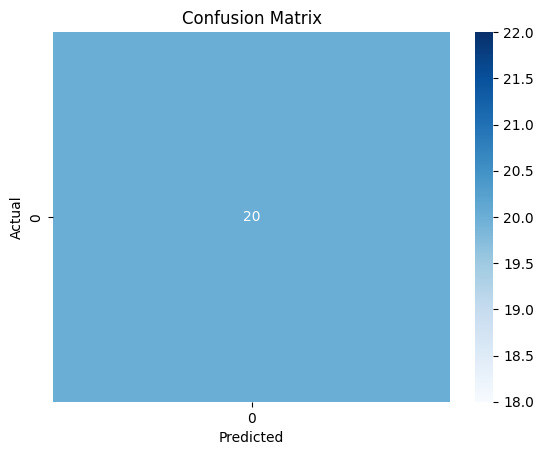

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()  # set model ke mode evaluasi
all_preds = []
all_labels = []

with torch.no_grad():
    for mfccs, labels in test_loader:
        mfccs = mfccs.to(device)
        labels = labels.to(device)
        outputs = model(mfccs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [11]:
from collections import Counter
print("Distribusi label di test set:", Counter(test_labels))


Distribusi label di test set: Counter({1: 20})


In [12]:
torch.save(model.state_dict(), "asthma_resnet_model.pt")
